# API Documentation Optimizer using TextGrad

This notebook demonstrates how to use TextGrad to optimize API documentation through iterative feedback. The system evaluates the documentation, generates feedback, and improves it automatically.

You can use either:
- OpenAI API models (GPT-3.5, GPT-4)
- Local models with LMStudio

## Setup and Installation

First, let's install the required packages:

In [1]:
!pip install openai textgrad matplotlib pandas seaborn

  Using cached matplotlib-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.8 MB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)


## Import Libraries

In [91]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import textgrad as tg
import time
from IPython.display import display, HTML, Markdown
from textgrad.engine_experimental.openai import OpenAIEngine
from textgrad.engine import get_engine
from textgrad.engine import get_engine
from textgrad import Variable
from textgrad.optimizer import TextualGradientDescent
from textgrad.loss import TextLoss
from dotenv import load_dotenv
import litellm
litellm.set_verbose=True
import numpy as np
from peft import PeftConfig, PeftModel
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
from typing import Dict, List, Any, Optional, Tuple

## Configure TextGrad Engine

You can choose between using OpenAI API or a local model with LMStudio. Uncomment the appropriate section.

In [2]:
engine = get_engine("experimental:gpt-4o-mini", cache=False)
engine.generate(content="hello, what's 3+4", system_prompt="you are an assistant")

12:28:02 - LiteLLM:WARNING: utils.py:503 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.


SYNC kwargs[caching]: False; litellm.cache: None; kwargs.get('cache')['no-cache']: False
Final returned optional params: {'extra_body': {}}
RAW RESPONSE:
{"id": "chatcmpl-BNwRHIBKRBB8cRqNYxV9VmGv76NGN", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "Hello! 3 + 4 equals 7.", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}}], "created": 1745045883, "model": "gpt-4o-mini-2024-07-18", "object": "chat.completion", "service_tier": "default", "system_fingerprint": "fp_0392822090", "usage": {"completion_tokens": 12, "prompt_tokens": 22, "total_tokens": 34, "completion_tokens_details": {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}, "prompt_tokens_details": {"audio_tokens": 0, "cached_tokens": 0}}}




'Hello! 3 + 4 equals 7.'

In [53]:
class PeftModelAdapter:
    """Adapter to make PEFT models compatible with TextGrad's interface."""
    
    def __init__(self, model_dir, temperature=0.1):
        """Initialize the PEFT model adapter."""
        # Load PEFT model using the correct sequence
        self.config = PeftConfig.from_pretrained(model_dir)
        self.base_model = AutoModelForSeq2SeqLM.from_pretrained(self.config.base_model_name_or_path)
        self.model = PeftModel.from_pretrained(self.base_model, model_dir)
        self.tokenizer = AutoTokenizer.from_pretrained(self.config.base_model_name_or_path)
        self.temperature = temperature
        
    def generate(self, content, system_prompt=None):
        """Generate text based on input content following TextGrad's interface."""
        # Combine system prompt and content if provided
        if system_prompt:
            input_text = f"{system_prompt}\n\n{content}"
        else:
            input_text = content
        
        # Tokenize input
        inputs = self.tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
        
        # Generate response
        with torch.no_grad():
            # Create a dictionary of generation kwargs and pass it using **kwargs syntax
            generation_kwargs = {
                "input_ids": inputs["input_ids"],
                "max_new_tokens": 512,
                "do_sample": self.temperature > 0,
                "temperature": self.temperature if self.temperature > 0 else None
            }
            
            # This ensures all args are passed as keyword arguments
            outputs = self.model.generate(**generation_kwargs)
        
        # Decode response
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return response

In [67]:
import hashlib
import os
import diskcache as dc
from typing import Any, Optional

class PeftEngine:
    """Custom TextGrad engine implementation for PEFT models."""
    
    def __init__(self, model_dir, temperature=0.1, use_cache=True, cache_dir=".textgrad_cache"):
        """Initialize the PEFT engine.
        
        Args:
            model_dir: Directory containing the PEFT model
            temperature: Temperature for generation
            use_cache: Whether to cache responses
            cache_dir: Directory to store cached responses
        """
        
        # Create the PEFT model adapter
        self.model = PeftModelAdapter(model_dir=model_dir, temperature=temperature)
        self.temperature = temperature
        self.use_cache = use_cache
        self.cache_dir = cache_dir
        
        # Initialize cache if needed
        if self.use_cache:
            os.makedirs(self.cache_dir, exist_ok=True)
            self.cache = dc.Cache(self.cache_dir)
    def _process_textgrad_variable(self, var):
        """Helper method to extract value from TextGrad variables."""
        if hasattr(var, 'value'):
            return var.value
        return var

    
    def _hash_prompt(self, content: str, system_prompt: Optional[str] = None):
        """Create a hash for the prompt to use as cache key."""
        combined = f"{system_prompt if system_prompt else ''}|||{content}"
        return hashlib.sha256(combined.encode()).hexdigest()
    
    def generate(self, content: str, system_prompt: Optional[str] = None, **kwargs):
        """Generate text using the PEFT model."""

        content_text = self._process_textgrad_variable(content)
        system_prompt_text = self._process_textgrad_variable(system_prompt) if system_prompt else None
    

        # Check cache first if enabled
        if self.use_cache:
            cache_key = self._hash_prompt(content, system_prompt)
            cached_result = self.cache.get(cache_key)
            if cached_result is not None:
                return cached_result
        
        # Generate response using the model
        response = self.model.generate(content=content_text, system_prompt=system_prompt_text)

        
        # Cache the result if enabled
        if self.use_cache:
            self.cache[cache_key] = response
        
        return response
    
    def __call__(self, content: str, system_prompt: Optional[str] = None, **kwargs):
        """Make the engine callable, same as generate."""
        return self.generate(content=content, system_prompt=system_prompt, **kwargs)


# TextGrad backward engine compatibility
class PeftBackwardEngine(PeftEngine):
    """Backward engine implementation for TextGrad's gradient computation."""
    
    # Update the backward method in the PeftBackwardEngine class

    def backward(self, output, content=None, system_prompt=None, **kwargs):
        """Generate gradients for TextGrad optimization."""
        # Process the inputs
        if isinstance(output, str):
            output_text = output
        else:
            output_text = output.value if hasattr(output, 'value') else str(output)
        
        if content is None:
            return {"gradient": "This is a new improved documentation."}
        
        content_text = content.value if hasattr(content, 'value') else str(content)
        
        # Create a much more specific prompt that will generate usable gradient text
        gradient_prompt = f"""
        You are a documentation improvement expert. Your task is to REWRITE the API documentation 
        to directly address the issues mentioned in the evaluation.
        
        Current documentation:
        ```
        {content_text}
        ```
        
        Evaluation of current documentation:
        ```
        {output_text}
        ```
        
        IMPORTANT: Don't explain what changes to make. Instead, provide the COMPLETE REVISED DOCUMENTATION
        with all improvements already implemented. The output should be ONLY the updated documentation text
        that can directly replace the original.
        
        Generate the improved documentation now:
        """
        
        # Generate the improved documentation directly
        improved_doc = self.model.generate(content=gradient_prompt, system_prompt=None)
        
        # TextGrad expects a dict with a "gradient" key
        # The value should be text that can directly improve the original content
        return {"gradient": improved_doc}

In [68]:
peft_adapter = PeftModelAdapter(
                model_dir="api-docs-model",
                temperature=0.7
            )

In [69]:
engine = PeftBackwardEngine(
                model_dir="api-docs-model",
                temperature=0.7,
                use_cache=True
            )

In [71]:
engine.generate("hello, what's 3+4")

'3 + 4 is the same as 3 + 4'

In [ ]:
#Choose your engine type: 'openai' or 'local'
engine_type = 'local'  # Change to 'local' to use LMStudio

if engine_type == 'openai':
    # Option 1: OpenAI API
    from textgrad.engine.openai import ChatOpenAI
    
    # Set your OpenAI API key
    os.environ["OPENAI_API_KEY"] = "INSERT API KEY HERE"  # Replace with your actual API key
    
    # Choose model: 'gpt-3.5-turbo' or 'gpt-4'
    model_name = 'gpt-4o'  # Example model, change as needed
    
    # Initialize TextGrad engine
    backward_engine = get_engine("experimental:gpt-4o-mini", cache=False)

    
else:  # 'local'
    # Option 2: Local model with LMStudio
    from openai import OpenAI
    from textgrad.engine.local_model_openai_api import ChatExternalClient
    
    # Make sure LMStudio is running with a local server at http://localhost:1234/v1
    client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")
    
    # Specify your model (this should match the model loaded in LMStudio)
    model_string = 'Llama-3.2-1B-Instruct-Q8_0-GGUF/llama-3.2-1b-instruct-q8_0.gguf'  # Example model
    
    # Initialize TextGrad engine
    engine = ChatExternalClient(client=client, model_string=model_string)

# Set the TextGrad backward engine
tg.set_backward_engine(engine, override=True)

In [97]:
engine.generate(content="hello, what's 3+4", system_prompt="you are an assistant")

'The answer is: 7'

## Define API Documentation Example

Let's start with a simple API documentation example that we'll optimize.

In [98]:
# Initial API documentation example
initial_documentation = """
Description
Create a new user.

Parameters
name: User's name
age: User's age
email: User's email

Returns
The created user data

Examples
user = create_user(name="John", age=25)
"""

print(initial_documentation)


Description
Create a new user.

Parameters
name: User's name
age: User's age
email: User's email

Returns
The created user data

Examples
user = create_user(name="John", age=25)



## Create TextGrad Variables

Now, let's set up the TextGrad variables for our optimization process.

In [99]:
# Create a TextGrad variable for the documentation
documentation = tg.Variable(
    initial_documentation,
    requires_grad=True,
    role_description="API documentation that needs improvement"
)

# System prompt for the loss function
loss_system_prompt = tg.Variable(
    """You are an expert API documentation reviewer specializing in technical documentation.
    
    Evaluate the given API documentation for the following criteria:
    1. Completeness: Does it cover all essential elements (description, parameters, return values, examples)?
    2. Technical Accuracy: Is the information correct and precise?
    3. Clarity: Is the documentation easy to understand for developers?
    4. Organization: Is it well-structured with clear sections?
    5. Example Quality: Are the examples comprehensive and realistic?
    
    Identify specific problems in the documentation and provide detailed, constructive feedback on how to improve it.
    Focus on making the documentation more helpful for developers who will use the API.
    
    Be specific and detailed about what changes should be made to improve the documentation quality.
    Your feedback should identify concrete issues and suggest specific improvements.
    """,
    requires_grad=False,
    role_description="system prompt for documentation evaluation"
)

# Loss function
loss_fn = tg.TextLoss(loss_system_prompt, engine=engine)

# Optimizer
optimizer = tg.TGD([documentation], engine=engine)

In [100]:
# Check if engine is properly initialized
print("Engine type:", type(engine))
print("Engine configuration:", engine)

# Test engine with a simple prompt
test_prompt = tg.Variable(
    "Write a single word response: hello",
    requires_grad=False,
    role_description="test prompt"
)

try:
    test_response = engine.generate("Write a single word response: hello")
    print("Test response:", test_response)
    print("Test value:", test_response if test_response else None)
except Exception as e:
    print(f"Engine test failed: {e}")

Engine type: <class 'textgrad.engine.local_model_openai_api.ChatExternalClient'>
Engine configuration: <textgrad.engine.local_model_openai_api.ChatExternalClient object at 0x77f860b79bd0>
Test response: Hi!
Test value: Hi!


## Evaluate Initial Documentation

Before optimization, let's evaluate the initial documentation and get scores for different quality metrics.

In [101]:
def evaluate_documentation(doc_text):
    """Evaluate API documentation and return scores."""
    # Create the evaluation prompt as a string, not a Variable
    eval_prompt_text = f"""
    Please evaluate the following API documentation on a scale of 0-10 for each criterion:
    
    - Completeness (0-10): Does it cover all essential information?
    - Technical Accuracy (0-10): Is the information correct and precise?
    - Clarity (0-10): Is it easy to understand?
    - Organization (0-10): Is it well-structured?
    - Example Quality (0-10): Are examples helpful and realistic?
    - Overall Quality (0-10): Overall assessment
    
    Documentation to evaluate:
    ```
    {doc_text}
    ```
    
    Provide your evaluation in JSON format like this:
    {{
        "completeness": score,
        "accuracy": score,
        "clarity": score,
        "organization": score,
        "examples": score,
        "overall": score,
        "feedback": "Your detailed feedback here"
    }}
    
    Include the JSON in your response.
    """
    
    # Generate response with string parameters, not Variable objects
    print("Sending evaluation request...")
    try:
        response = backward_engine.generate(
            content="Please evaluate the documentation according to the criteria provided.",
            system_prompt=eval_prompt_text
        )
        print(f"Response received: {type(response)}")
        
        # Extract JSON from response
        try:
            json_start = response.find('{')
            json_end = response.rfind('}') + 1
            
            if json_start >= 0 and json_end > json_start:
                json_str = response[json_start:json_end]
                scores = json.loads(json_str)
            else:
                # Fallback
                scores = {
                    "completeness": 5,
                    "accuracy": 5,
                    "clarity": 5,
                    "organization": 5,
                    "examples": 5,
                    "overall": 5,
                    "feedback": "Failed to parse evaluation"
                }
        except json.JSONDecodeError:
            scores = {
                "completeness": 5,
                "accuracy": 5,
                "clarity": 5,
                "organization": 5,
                "examples": 5,
                "overall": 5,
                "feedback": "Failed to parse evaluation response"
            }
        
        return scores
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        return {
            "completeness": 5,
            "accuracy": 5,
            "clarity": 5,
            "organization": 5,
            "examples": 5, 
            "overall": 5,
            "feedback": f"Error during evaluation: {str(e)}"
        }
# Evaluate initial documentation
print("Evaluating initial documentation...")
initial_scores = evaluate_documentation(initial_documentation)

# Display results
print("\nInitial Documentation Evaluation:")
print(f"- Completeness: {initial_scores.get('completeness', 'N/A')}/10")
print(f"- Technical Accuracy: {initial_scores.get('accuracy', 'N/A')}/10")
print(f"- Clarity: {initial_scores.get('clarity', 'N/A')}/10")
print(f"- Organization: {initial_scores.get('organization', 'N/A')}/10")
print(f"- Example Quality: {initial_scores.get('examples', 'N/A')}/10")
print(f"- Overall Quality: {initial_scores.get('overall', 'N/A')}/10")
print(f"\nFeedback: {initial_scores.get('feedback', 'N/A')}")

12:55:33 - LiteLLM:WARNING: utils.py:503 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.


Evaluating initial documentation...
Sending evaluation request...
SYNC kwargs[caching]: False; litellm.cache: None; kwargs.get('cache')['no-cache']: False
Final returned optional params: {'extra_body': {}}
RAW RESPONSE:
{"id": "chatcmpl-BNwrtWokCd5B42Q1DBrnWYyUuZwJC", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "{\n    \"completeness\": 5,\n    \"accuracy\": 8,\n    \"clarity\": 7,\n    \"organization\": 6,\n    \"examples\": 5,\n    \"overall\": 6,\n    \"feedback\": \"The documentation provides a basic overview of how to create a user but lacks detailed descriptions of parameters, such as the type of data expected for each field (e.g., string for name, integer for age). There is no information about error handling or edge cases. The return value is vaguely described as 'the created user data,' which could benefit from more detail on the structure of the return object. The example provided is simple but lacks context regarding its expecte

## Run the TextGrad Optimization Loop

Now let's run the optimization process to improve the documentation through multiple iterations.

In [102]:
def manual_update(documentation, feedback):
    """Manually update documentation based on feedback when optimizer fails."""
    # Create an explicit prompt for the model to generate improved documentation
    update_prompt = f"""
    Please improve this documentation based on the feedback:

    CURRENT DOCUMENTATION:
    {documentation}

    FEEDBACK:
    {feedback}

    IMPORTANT: Provide ONLY the complete improved documentation text, without explanations.
    """
    
    improved_doc = engine.generate(content=update_prompt)
    return improved_doc

In [103]:
# Number of optimization iterations
iterations = 3

# Store optimization history for visualization
history = {
    "iteration": [0],
    "documentation": [documentation.value],
    "feedback": ["Initial version"]
}

# Optimization loop
for i in range(iterations):
    print(f"\n--- Iteration {i+1}/{iterations} ---")
    print("Evaluating documentation...")
    
    # Compute loss (evaluation)
    start_time = time.time()
    try:
        loss = loss_fn(documentation)
        print(f"Feedback (took {time.time() - start_time:.2f}s):")
        print(loss.value)
    except Exception as e:
        print(f"Error computing loss: {e}")
        continue
    
    print("\nComputing improvements...")
    # Try the optimizer's backward/step process
    try:
        # Backward pass
        start_time = time.time()
        loss.backward()
        print(f"Backward pass took {time.time() - start_time:.2f}s")
        
        print("Applying improvements...")
        # Update the documentation
        optimizer.step()
    except IndexError as e:
        # If optimizer fails, use manual update
        print(f"Optimizer error: {e}")
        print("Falling back to manual update...")
        improved_doc = manual_update(documentation.value, loss.value)
        documentation.value = improved_doc
    
    # Store in history
    history["iteration"].append(i+1)
    history["documentation"].append(documentation.value)
    history["feedback"].append(loss.value)
    
    print(f"\nUpdated documentation (iteration {i+1}):")
    print(documentation.value)


--- Iteration 1/3 ---
Evaluating documentation...
Feedback (took 0.01s):
**Evaluation**

Overall, the API documentation is clear and concise. However, there are some areas that can be improved to make it more helpful for developers.

**Strengths:**

* The description of the `create_user` method is straightforward.
* The parameters and return values are clearly listed.
* The examples provided are simple and easy to understand.

**Weaknesses:**

1. **Lack of validation**: There is no validation on the input parameters, which could lead to errors if invalid data is passed in. For example, what happens if `name` or `age` is not a string?
2. **No error handling**: The API does not handle errors that may occur during execution. What happens if the database cannot be connected or if there are issues with the user's email address?
3. **Missing documentation on data types**: While the parameters and return values are listed, it would be helpful to know what type of data is expected for each pa

## Evaluate Final Documentation

Let's evaluate the final optimized documentation and see how it improved.

In [104]:
# Evaluate final documentation
print("Evaluating final optimized documentation...")
final_scores = evaluate_documentation(documentation.value)

# Display results
print("\nFinal Documentation Evaluation:")
print(f"- Completeness: {final_scores.get('completeness', 'N/A')}/10")
print(f"- Technical Accuracy: {final_scores.get('accuracy', 'N/A')}/10")
print(f"- Clarity: {final_scores.get('clarity', 'N/A')}/10")
print(f"- Organization: {final_scores.get('organization', 'N/A')}/10")
print(f"- Example Quality: {final_scores.get('examples', 'N/A')}/10")
print(f"- Overall Quality: {final_scores.get('overall', 'N/A')}/10")
print(f"\nFeedback: {final_scores.get('feedback', 'N/A')}")

12:59:41 - LiteLLM:WARNING: utils.py:503 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.


Evaluating final optimized documentation...
Sending evaluation request...
SYNC kwargs[caching]: False; litellm.cache: None; kwargs.get('cache')['no-cache']: False
Final returned optional params: {'extra_body': {}}
RAW RESPONSE:
{"id": "chatcmpl-BNwvvMcC3FgnC01KlQFv4ZX01fhLN", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "```json\n{\n    \"completeness\": 6,\n    \"accuracy\": 8,\n    \"clarity\": 7,\n    \"organization\": 5,\n    \"examples\": 6,\n    \"overall\": 6,\n    \"feedback\": \"The documentation provides essential information about creating a new user but lacks details on return types, HTTP status codes, and specific exceptions. While the parameters and their types are defined, there are no endpoints provided, which is crucial for API documentation. The explanation is somewhat clear, but the overall organization is muddled with inconsistent sections and unclear headers. The example given is a simple call, which is helpful, but mor

## Visualize Improvement

Let's create some visualizations to see how the documentation improved through iterations.

Metric  Initial  Final  Improvement
0        Completeness        5      6            1
1  Technical Accuracy        8      8            0
2             Clarity        7      7            0
3        Organization        6      5           -1
4     Example Quality        5      6            1
5     Overall Quality        6      6            0

<Figure size 1200x600 with 0 Axes>

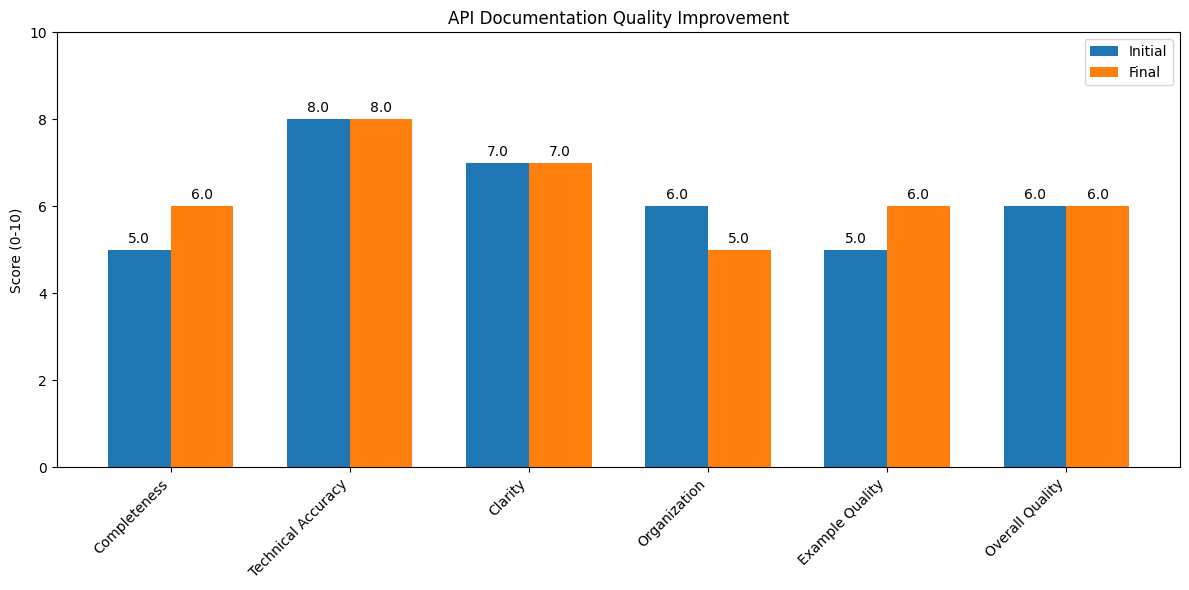

In [105]:
# Create a comparison table with before and after scores
score_comparison = pd.DataFrame([
    {
        'Metric': 'Completeness',
        'Initial': initial_scores.get('completeness', 0),
        'Final': final_scores.get('completeness', 0),
        'Improvement': final_scores.get('completeness', 0) - initial_scores.get('completeness', 0)
    },
    {
        'Metric': 'Technical Accuracy',
        'Initial': initial_scores.get('accuracy', 0),
        'Final': final_scores.get('accuracy', 0),
        'Improvement': final_scores.get('accuracy', 0) - initial_scores.get('accuracy', 0)
    },
    {
        'Metric': 'Clarity',
        'Initial': initial_scores.get('clarity', 0),
        'Final': final_scores.get('clarity', 0),
        'Improvement': final_scores.get('clarity', 0) - initial_scores.get('clarity', 0)
    },
    {
        'Metric': 'Organization',
        'Initial': initial_scores.get('organization', 0),
        'Final': final_scores.get('organization', 0),
        'Improvement': final_scores.get('organization', 0) - initial_scores.get('organization', 0)
    },
    {
        'Metric': 'Example Quality',
        'Initial': initial_scores.get('examples', 0),
        'Final': final_scores.get('examples', 0),
        'Improvement': final_scores.get('examples', 0) - initial_scores.get('examples', 0)
    },
    {
        'Metric': 'Overall Quality',
        'Initial': initial_scores.get('overall', 0),
        'Final': final_scores.get('overall', 0),
        'Improvement': final_scores.get('overall', 0) - initial_scores.get('overall', 0)
    }
])

display(score_comparison)

# Create a bar chart to visualize the improvement
plt.figure(figsize=(12, 6))
x = score_comparison['Metric']
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x=np.arange(len(x)) - width/2, height=score_comparison['Initial'], width=width, label='Initial')
rects2 = ax.bar(x=np.arange(len(x)) + width/2, height=score_comparison['Final'], width=width, label='Final')

ax.set_ylabel('Score (0-10)')
ax.set_title('API Documentation Quality Improvement')
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 10)

# Add value labels
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                   xy=(rect.get_x() + rect.get_width()/2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()
plt.show()

## Custom API Documentation Optimization

Now that you've seen how it works, you can optimize your own API documentation snippet. Just enter your documentation below and run the optimization process.

In [ ]:
# Enter your own API documentation here
your_documentation = """
# Replace this with your API documentation
Description
Get user data.

Parameters
id: User ID

Returns
User data
"""

# Create a new TextGrad variable for your documentation
custom_doc = tg.Variable(
    your_documentation,
    requires_grad=True,
    role_description="API documentation that needs improvement"
)

# Create a new optimizer
custom_optimizer = tg.TGD([custom_doc])

# Run optimization (3 iterations)
for i in range(3):
    print(f"\n--- Iteration {i+1}/3 ---")
    
    # Compute loss
    loss = loss_fn(custom_doc)
    print(f"Feedback:\n{loss.value}\n")
    
    # Backward pass
    loss.backward()
    
    # Update the documentation
    custom_optimizer.step()
    
    print(f"Updated documentation:\n{custom_doc.value}\n")

# Display final optimized documentation
print("\nFinal Optimized Documentation:")
print(custom_doc.value)

## Conclusion

You've now seen how TextGrad can be used to automatically optimize API documentation through iterative feedback. This approach can be applied to improve various types of technical documentation, making it more complete, accurate, and user-friendly.

Key benefits of this approach include:
- Automated improvement of documentation quality
- Consistent evaluation across multiple metrics
- Identification of specific areas for improvement
- Iterative refinement based on expert feedback

This demonstrates the practical application of TextGrad's "automatic differentiation via text" framework specifically for technical documentation optimization.